# Working with Raster Data in Python

Python has an ecosystem of packages to work with Geospatial data. The most important packages to work with Raster data are:

- [Rasterio](https://rasterio.readthedocs.io/en/latest/index.html) is a highly useful module for raster processing which you can use for reading and writing [several different raster formats](https://gdal.org/drivers/raster/index.html) in Python. Rasterio is based on [GDAL](http://www.gdal.org/). Most common file formats that can be read with `Rasterio` include for example TIFF, GeoTIFF, ASCII Grid and Erdas Imagine (.img) files.
- [xarray]
- [rioxarray]


Let's start with inspecting one of the files in our local data repository:


## Reading raster file (rioxarray/rasterio)

In [2]:
import rioxarray
import os
%matplotlib inline

# Data dir
data_dir = "../data/Beeldmateriaal/"
fp = os.path.join(data_dir, "USP_4Band_RGBN.tif")

# Open the file:
raster = rioxarray.open_rasterio(fp, band_as_variable = True)

# Check type of the variable 'raster'
type(raster)

xarray.core.dataset.Dataset

## Exploring file structure (Dataset class)

In [21]:
raster

<xarray.Dataset>
Dimensions:      (x: 8204, y: 5956)
Coordinates:
  * x            (x) float64 1.395e+05 1.395e+05 ... 1.416e+05 1.416e+05
  * y            (y) float64 4.561e+05 4.561e+05 ... 4.546e+05 4.546e+05
    spatial_ref  int64 0
Data variables:
    band_1       (y, x) uint8 ...
    band_2       (y, x) uint8 ...
    band_3       (y, x) uint8 ...
    band_4       (y, x) uint8 ...
Attributes:
    AREA_OR_POINT:  Area

### extracting bands into separate objects

In [3]:
blue = raster["band_3"]
green = raster["band_2"]
red = raster["band_1"]
nir = raster["band_4"]
blue

<xarray.DataArray 'band_3' (y: 5956, x: 8204)>
[48863024 values with dtype=uint8]
Coordinates:
  * x            (x) float64 1.395e+05 1.395e+05 ... 1.416e+05 1.416e+05
  * y            (y) float64 4.561e+05 4.561e+05 ... 4.546e+05 4.546e+05
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  2893.64616988154,2647.237559987611,2703.46801314...
    STATISTICS_MAXIMUM:      255
    STATISTICS_MEAN:         88.773649907529
    STATISTICS_MEDIAN:       75,000000
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       51.994884490148
    scale_factor:            1.0
    add_offset:              0.0

In [23]:
print(red.rio.crs)
print(red.rio.nodata)
print(red.rio.bounds())
print(red.rio.width)
print(red.rio.height)

EPSG:28992
None
(139504.5, 454623.25, 141555.5, 456112.25)
8204
5956


### visualizing bands

In [ ]:
red.plot()

## CRS

In [4]:
from rasterio.crs import CRS

crs_wgs84 = CRS.from_string('EPSG:4326')

In [5]:
red_wgs84 = red.rio.reproject(crs_wgs84)

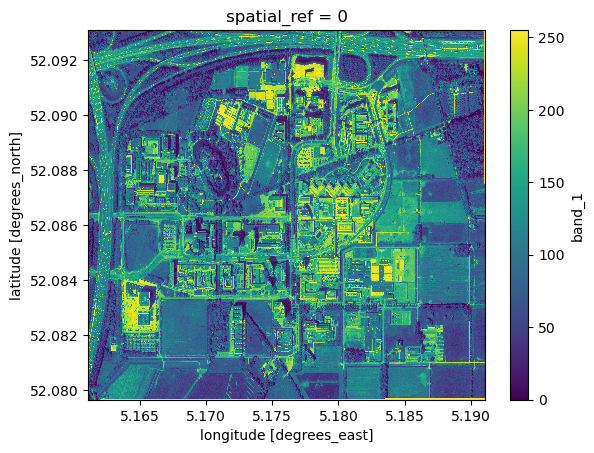

In [26]:
red_wgs84.plot()

## Cropping

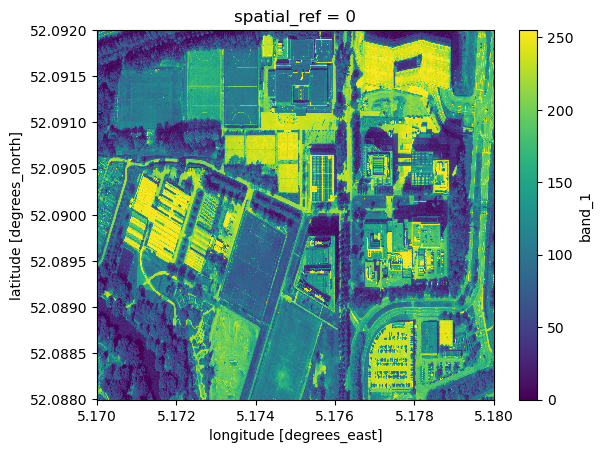

In [6]:
red_clipped = red_wgs84.rio.clip_box(
    minx=5.170,
    miny=52.088,
    maxx=5.180,
    maxy=52.092,
)
red_clipped.plot()

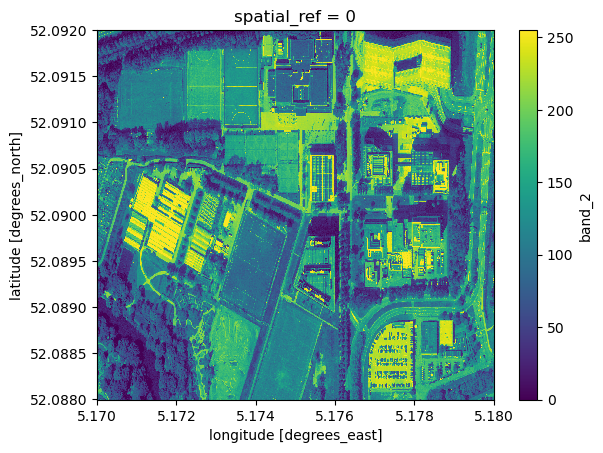

In [7]:
green_clipped = green.rio.reproject_match(red_clipped)
green_clipped.plot()

In [8]:
blue_clipped = blue.rio.reproject_match(red_clipped)
nir_clipped = nir.rio.reproject_match(red_clipped)

## Composing RGB

In [9]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red_clipped)
greenn = normalize(green_clipped)
bluen = normalize(blue_clipped)
nirn = normalize(nir_clipped)

print("Normalized bands")
print(redn.values.min(), '-', redn.values.max(), 'mean:', redn.values.mean())
print(greenn.values.min(), '-', greenn.values.max(), 'mean:', greenn.values.mean())
print(bluen.values.min(), '-', bluen.values.max(), 'mean:', bluen.values.mean())

Normalized bands
0.0 - 1.0 mean: 0.47605566423067236
0.0 - 1.0 mean: 0.4599640338458991
0.0 - 1.0 mean: 0.4039841718553451


In [10]:
import xarray as xr

# Create RGB natural color composite
#rgb = xr.merge([red_clipped, green_clipped, blue_clipped]).to_array()
rgb = xr.merge([redn, greenn, bluen]).to_array()

rgb

<xarray.DataArray (variable: 3, y: 1237, x: 3090)>
array([[[0.31372549, 0.32941176, 0.32156863, ..., 0.70196078,
         0.71764706, 0.74117647],
        [0.3254902 , 0.32941176, 0.38039216, ..., 0.69019608,
         0.70980392, 0.70196078],
        [0.2745098 , 0.25882353, 0.3254902 , ..., 0.68627451,
         0.71372549, 0.72941176],
        ...,
        [0.38039216, 0.41568627, 0.38039216, ..., 0.43137255,
         0.4       , 0.43137255],
        [0.34901961, 0.39607843, 0.39215686, ..., 0.38039216,
         0.36470588, 0.41176471],
        [0.37254902, 0.36470588, 0.39215686, ..., 0.43137255,
         0.3372549 , 0.41176471]],

       [[0.3372549 , 0.35294118, 0.34509804, ..., 0.62745098,
         0.65098039, 0.67843137],
        [0.34901961, 0.35294118, 0.41176471, ..., 0.61960784,
         0.63921569, 0.62745098],
        [0.27843137, 0.34901961, 0.3372549 , ..., 0.65098039,
         0.59607843, 0.78823529],
...
        [0.35294118, 0.39607843, 0.35294118, ..., 0.4       ,
         0.36470588, 0.4       ],
        [0.32156863, 0.37254902, 0.36470588, ..., 0.33333333,
         0.31372549, 0.36078431],
        [0.34509804, 0.3372549 , 0.36470588, ..., 0.38823529,
         0.26666667, 0.36470588]],

       [[0.21960784, 0.23921569, 0.22745098, ..., 0.59215686,
         0.61176471, 0.64313725],
        [0.23137255, 0.23921569, 0.30196078, ..., 0.58039216,
         0.6       , 0.59215686],
        [0.16078431, 0.23921569, 0.20784314, ..., 0.61176471,
         0.55686275, 0.75686275],
        ...,
        [0.2627451 , 0.30588235, 0.2627451 , ..., 0.31372549,
         0.2745098 , 0.31372549],
        [0.22745098, 0.28235294, 0.2745098 , ..., 0.22745098,
         0.20784314, 0.2745098 ],
        [0.25098039, 0.24313725, 0.2745098 , ..., 0.29019608,
         0.16078431, 0.2627451 ]]])
Coordinates:
  * x            (x) float64 5.17 5.17 5.17 5.17 5.17 ... 5.18 5.18 5.18 5.18
  * y            (y) float64 52.09 52.09 52.09 52.09 ... 52.09 52.09 52.09 52.09
    spatial_ref  int64 0
  * variable     (variable) object 'band_1' 'band_2' 'band_3'

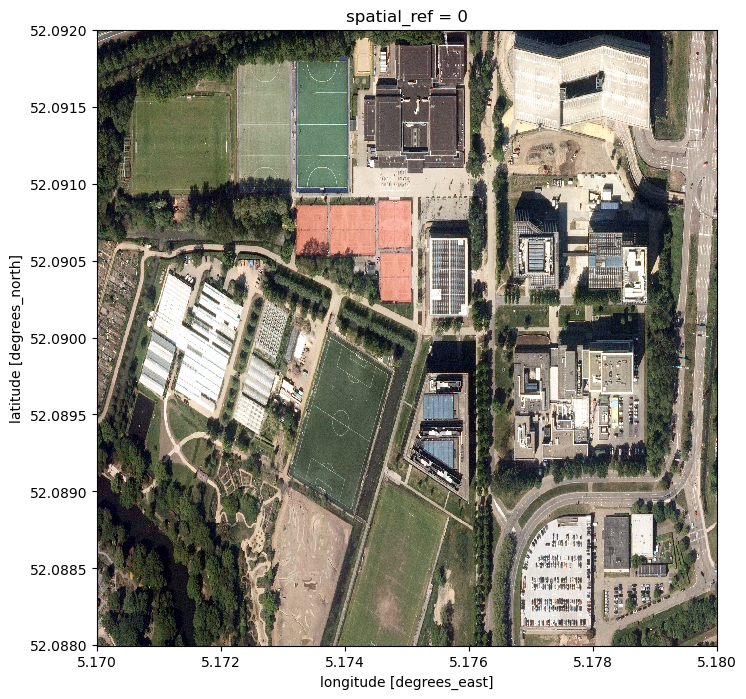

In [32]:
rgb.plot.imshow(figsize=(8,8))

## NDVI and raster maths

In [33]:
print(red_clipped.shape)
print(nir_clipped.shape)

(1237, 3090)
(1237, 3090)


In [11]:
ndvi = (nirn - redn)/ (nirn + redn)

In [12]:
ndvi

<xarray.DataArray (y: 1237, x: 3090)>
array([[ 0.44636678,  0.43434343,  0.4440678 , ..., -0.12578616,
        -0.11926606, -0.11176471],
       [ 0.43537415,  0.43434343,  0.40123457, ..., -0.12820513,
        -0.1242236 , -0.12225705],
       [ 0.46969697,  0.52173913,  0.42758621, ..., -0.10759494,
        -0.16666667, -0.00540541],
       ...,
       [ 0.34459459,  0.32698413,  0.33788396, ...,  0.30599369,
         0.32      ,  0.29487179],
       [ 0.36654804,  0.33770492,  0.33774834, ...,  0.31690141,
         0.32608696,  0.28813559],
       [ 0.34482759,  0.35416667,  0.33774834, ...,  0.28571429,
         0.328125  ,  0.2733564 ]])
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 5.17 5.17 5.17 5.17 5.17 ... 5.18 5.18 5.18 5.18
  * y            (y) float64 52.09 52.09 52.09 52.09 ... 52.09 52.09 52.09 52.09

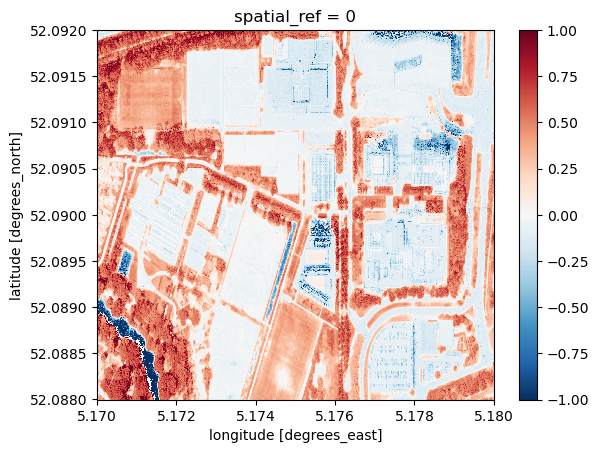

In [54]:
ndvi.plot()

## plot statistics (histogram)

(array([  30388.,   15582.,   40447.,  138340., 1601334.,  431641.,
         627964.,  653108.,  224044.,   55245.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

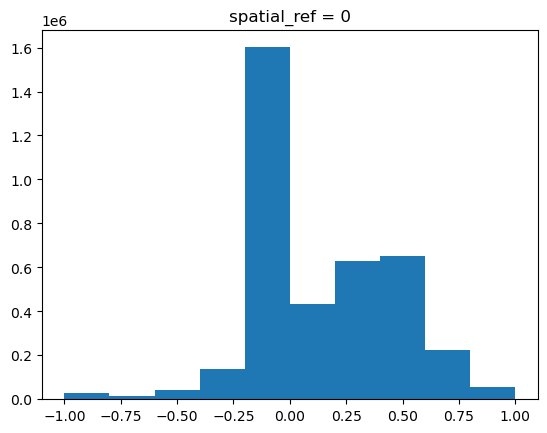

In [55]:
ndvi.plot.hist()

In [13]:
ndvi_nonan = ndvi.interpolate_na(dim="x")
ndvi_nonan.rio.to_raster("NDVI.tif")

## Image classification

In [20]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, -0.35, 0.2, 0.5, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this using
# xarray.apply_ufunc, which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins
)

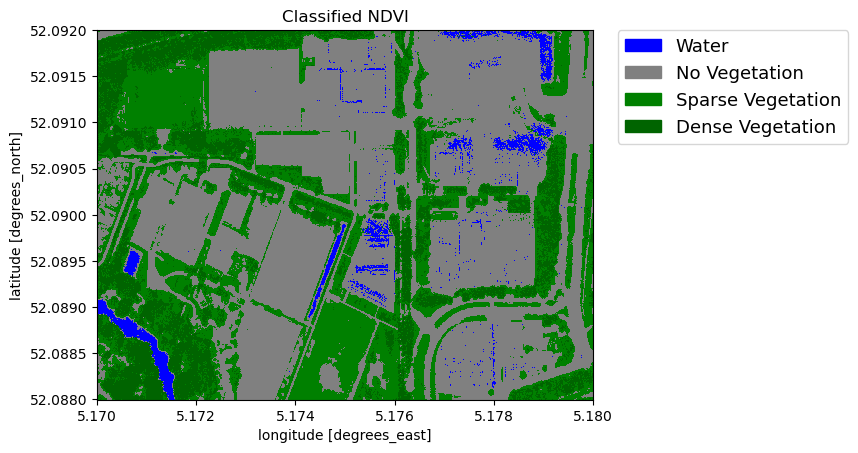

In [21]:
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure
plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

## Main concluding messages
Advantages (repeatable, exact, scalable, publishable)